# CPSC 330 hw8

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

## Instructions
rubric={points:5}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

## Dataset
rubric={points:5}

For this assignment, you can choose any reasonable dataset for supervised learning. Here is a list of Kaggle datasets in CSV format: https://www.kaggle.com/datasets?fileType=csv. You can also pick a dataset from your own hobby project or research project. 

If it's not already clear from the dataset, you will need to choose which column you are trying to predict. 

This week, you will build ML models on your dataset. Next week (hw9), you'll write a blog post about your work.

Your task here for these 5 points is to describe where you got the data from. If from Kaggle or another online source, poviding a link is sufficient. If from elsewhere, please elaborate.

#### Answer:

The data comes from the `games.csv` dataset on Kaggle, available [here](https://www.kaggle.com/nathanlauga/nba-games).

In [2]:
games_df = pd.read_csv('data/games.csv')
games_df.head()
# games_df = games_df.sample(frac=0.25, random_state=123) # To speed up running by only selecting a sample

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2020-03-01,21900895,Final,1610612766,1610612749,2019,1610612766,85.0,0.354,0.900,...,22.0,47.0,1610612749,93.0,0.402,0.762,0.226,20.0,61.0,0
1,2020-03-01,21900896,Final,1610612750,1610612742,2019,1610612750,91.0,0.364,0.400,...,19.0,57.0,1610612742,111.0,0.468,0.632,0.275,28.0,56.0,0
2,2020-03-01,21900897,Final,1610612746,1610612755,2019,1610612746,136.0,0.592,0.805,...,25.0,37.0,1610612755,130.0,0.505,0.650,0.488,27.0,37.0,1
3,2020-03-01,21900898,Final,1610612743,1610612761,2019,1610612743,133.0,0.566,0.700,...,38.0,41.0,1610612761,118.0,0.461,0.897,0.263,24.0,36.0,1
4,2020-03-01,21900899,Final,1610612758,1610612765,2019,1610612758,106.0,0.407,0.885,...,18.0,51.0,1610612765,100.0,0.413,0.667,0.429,23.0,42.0,1


## Exercise 1
rubric={points:10}

For your dataset: 

- Describe your goal (e.g. what you are trying to predict).
- Describe a (possibly fictional) scenario where someone in the real world is interested in this task and why it is useful to them. 
- What is the **decision** that ML is going to help make and what are the alternatives?

Max 1 paragraph total.

#### Answer:

The goal of this project is to classify a game as a 'win' (1) or a 'loss' (0) based on the various statistical categories of the team under consideration (home team) and their opponent (away team); the target is `HOME_TEAM_WINS`. In an increasingly statistics-driven league, a good classifier could allow a coach perform scenario analysis. First, they would use their opponent's season averages as a heuristic for how their opponent will perform in each statistical category in the upcoming game. Then, the coach could make *decisions* on tradeoffs between players in an attempt to target increasing certain statistical categories for their own team that they believe will give them the edge in the matchup. For example, a coach may estimate a higher 3 point percentage but lower amount of rebounds if they give a certain player (like Stephen Curry) more minutes, and this tradeoff might turn a loss into a win. The classifier helps because if the coach can estimate their team's statistical categories based on their knowledge of the players, they can run through different scenarios to see if the model predicts a win, and potentially use `predict_proba` or similar to evaluate the confidence of a win against a particular opponent. The alternative is using pure coaching experience and qualitative observations, for example by observing trends with players that have a 'hot hand' during a given period of time. However, this is not mutually exclusive, and would likely be used in conjunction with the model.

## Exercise 2

Build a model for your chosen problem. Your work must involve the following elements (the list is broken up between the sub-parts):

- Split your data into train/test

#### Answer:

In [3]:
train, test = train_test_split(games_df, test_size=0.2, random_state=123)

#### 2(a)
rubric={points:10}

- Perform exploratory data analysis, including outlier detection. 

#### Answer:

##### Summary Statistics
A few things to note from the below data:
* Data ranges from the (`min`) 2003 season to the (`max`) 2019 season.
* Home teams on average score *slightly* higher statistics, but this difference is usually well within the standard deviation, so we won't consider home team advantage here.

In [4]:
features_to_explore = ['SEASON', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']
train[features_to_explore].describe()

,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away
count,18556.000000,18479.000000,18479.000000,18479.000000,18479.000000,18479.000000,18479.000000,18479.000000,18479.000000,18479.000000,18479.000000,18479.000000,18479.000000
mean,2010.832238,102.130851,0.459803,0.758240,0.355978,22.509281,43.152119,99.162833,0.448269,0.755723,0.349111,21.112723,41.854971
std,4.828332,12.927235,0.056871,0.100405,0.114889,5.160757,6.554497,12.957771,0.055599,0.103245,0.112632,5.068244,6.495927
min,2003.000000,36.000000,0.250000,0.143000,0.000000,7.000000,17.000000,33.000000,0.244000,0.143000,0.000000,4.000000,19.000000
25%,2007.000000,93.000000,0.420000,0.696000,0.281000,19.000000,39.000000,90.000000,0.410000,0.692000,0.276000,18.000000,37.000000
50%,2011.000000,102.000000,0.459000,0.765000,0.355000,22.000000,43.000000,99.000000,0.447000,0.762000,0.348000,21.000000,42.000000
75%,2015.000000,111.000000,0.500000,0.826000,0.429000,26.000000,47.000000,108.000000,0.486000,0.826000,0.421000,24.000000,46.000000
max,2019.000000,168.000000,0.684000,1.000000,1.000000,47.000000,72.000000,161.000000,0.674000,1.000000,1.000000,43.000000,81.000000


##### Data Imbalance

The home team wins ~60% of the time, so this is not a terribly imbalanced dataset.

In [5]:
train['HOME_TEAM_WINS'].value_counts().loc[1]/len(train)

0.5918301358051304

##### Missing Values

From the code below, we can see that we have 18556 - 18479 = 77 missing values. We can also gather this from the profiling report, but I've commented it out to save runtime.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18556 entries, 15085 to 19966
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     18556 non-null  object 
 1   GAME_ID           18556 non-null  int64  
 2   GAME_STATUS_TEXT  18556 non-null  object 
 3   HOME_TEAM_ID      18556 non-null  int64  
 4   VISITOR_TEAM_ID   18556 non-null  int64  
 5   SEASON            18556 non-null  int64  
 6   TEAM_ID_home      18556 non-null  int64  
 7   PTS_home          18479 non-null  float64
 8   FG_PCT_home       18479 non-null  float64
 9   FT_PCT_home       18479 non-null  float64
 10  FG3_PCT_home      18479 non-null  float64
 11  AST_home          18479 non-null  float64
 12  REB_home          18479 non-null  float64
 13  TEAM_ID_away      18556 non-null  int64  
 14  PTS_away          18479 non-null  float64
 15  FG_PCT_away       18479 non-null  float64
 16  FT_PCT_away       18479 non-null  fl

In [7]:
# profile = ProfileReport(train, title='Profiling Report for NBA Games Data', minimal=True)

In [8]:
# profile.to_notebook_iframe();

Imputing values for missing data doesn't make sense, because we would have to impute data along every relavant feature for the problematic examples, which isn't really useful. Instead, we'll drop them, which shouldn't be an issue because we still have lots of data remaining.

In [9]:
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18479 entries, 15085 to 19966
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     18479 non-null  object 
 1   GAME_ID           18479 non-null  int64  
 2   GAME_STATUS_TEXT  18479 non-null  object 
 3   HOME_TEAM_ID      18479 non-null  int64  
 4   VISITOR_TEAM_ID   18479 non-null  int64  
 5   SEASON            18479 non-null  int64  
 6   TEAM_ID_home      18479 non-null  int64  
 7   PTS_home          18479 non-null  float64
 8   FG_PCT_home       18479 non-null  float64
 9   FT_PCT_home       18479 non-null  float64
 10  FG3_PCT_home      18479 non-null  float64
 11  AST_home          18479 non-null  float64
 12  REB_home          18479 non-null  float64
 13  TEAM_ID_away      18479 non-null  int64  
 14  PTS_away          18479 non-null  float64
 15  FG_PCT_away       18479 non-null  float64
 16  FT_PCT_away       18479 non-null  fl

##### Known Outlier Detection

From our summary stats, there was a home team that scored only 36 points and away team that scored only 33. This is an error, given that the lowest scoring home team since the 2003 season scored 59 points, and the lowest scoring away team since the 2003 season scored 54 points, [source here](https://www.statmuse.com/nba/ask/lowest-scoring-by-a-team-nba-game-since-2000).

In [10]:
train[(train.PTS_home < 60) | (train.PTS_away < 55)]

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
9125,2008-03-19,20701006,Final,1610612761,1610612748,2007,1610612761,96.0,0.542,0.733,...,29.0,49.0,1610612748,54.0,0.256,0.900,0.217,12.0,34.0,1
5231,2011-01-21,21000631,Final,1610612737,1610612740,2010,1610612737,59.0,0.291,0.818,...,11.0,32.0,1610612740,100.0,0.480,0.909,0.533,26.0,55.0,0
3851,2012-03-19,21100673,Final,1610612753,1610612741,2011,1610612753,59.0,0.353,0.389,...,9.0,38.0,1610612741,85.0,0.443,0.727,0.389,19.0,48.0,0
10176,2007-10-19,10700072,Final,1610612738,1610612751,2007,1610612738,36.0,0.414,0.750,...,8.0,18.0,1610612751,33.0,0.290,0.722,0.333,7.0,19.0,1


The first three examples are real games from the source above, but the last one, where both these minimums occur, is not.

In [11]:
train = train.drop(10176)

In [12]:
train[(train.PTS_home < 60) | (train.PTS_away < 55)]

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
9125,2008-03-19,20701006,Final,1610612761,1610612748,2007,1610612761,96.0,0.542,0.733,...,29.0,49.0,1610612748,54.0,0.256,0.900,0.217,12.0,34.0,1
5231,2011-01-21,21000631,Final,1610612737,1610612740,2010,1610612737,59.0,0.291,0.818,...,11.0,32.0,1610612740,100.0,0.480,0.909,0.533,26.0,55.0,0
3851,2012-03-19,21100673,Final,1610612753,1610612741,2011,1610612753,59.0,0.353,0.389,...,9.0,38.0,1610612741,85.0,0.443,0.727,0.389,19.0,48.0,0


##### Visual Outlier Detection

Given the distributions below, it seems there is no need for the use of isolation forests, because no clear outliers are visible. The one stat I questioned was the games with 1.0 `FG3_PCT_home` and `FG3_PCT_away` values (the 3 point percentage of a team) because it seemed unusually high. After exploring [this source](https://www.statmuse.com/nba/ask?q=highest+3p%25+by+a+team+in+a+regular+season+nba+game), I was surprised to learn teams actually achieve this statistic, so decided to keep these values. I also kept the examples with low free-throw shooting (`FT_PCT_home` and `FT_PCT_away`) because teams actually had poor shooting nights, and dropping these would skew the data.

In [13]:
visualized_features = ['PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']

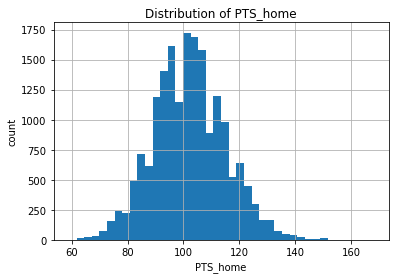

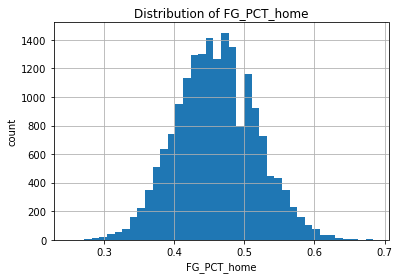

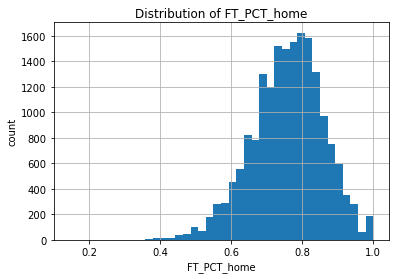

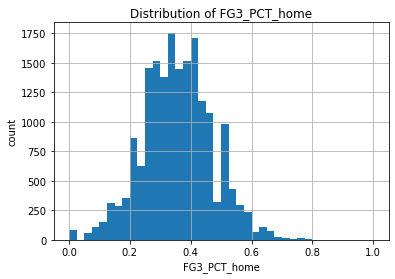

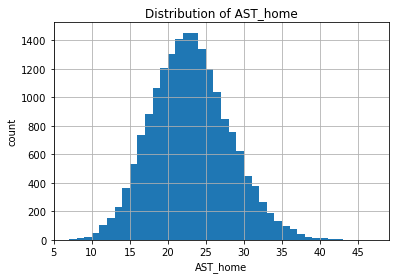

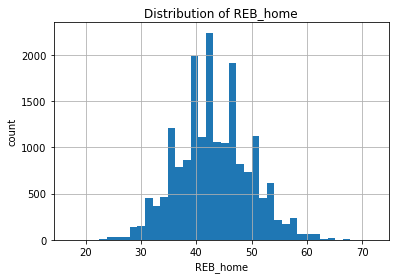

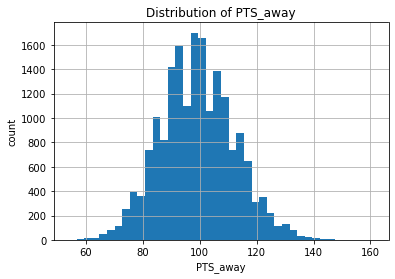

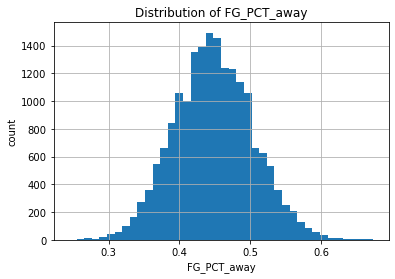

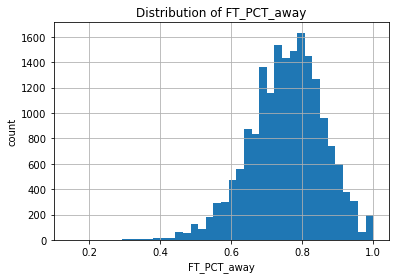

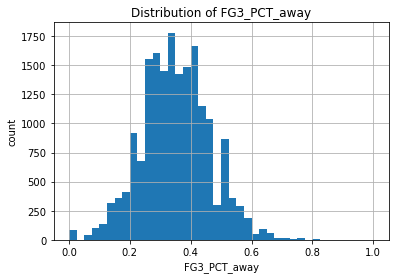

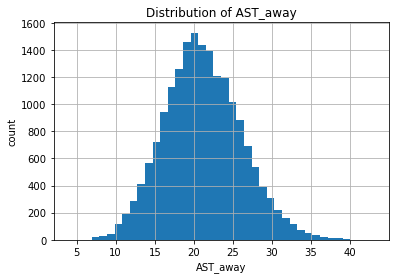

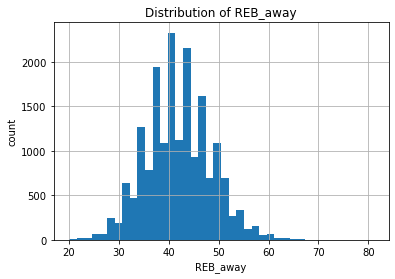

In [14]:
for feature in visualized_features:
    train[feature].hist(bins=40)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()

##### (Bonus) Target Splits by Feature

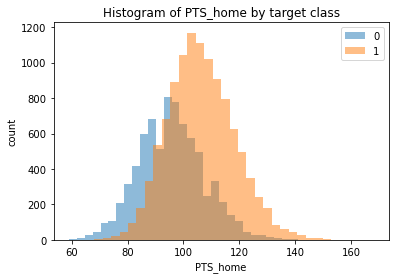

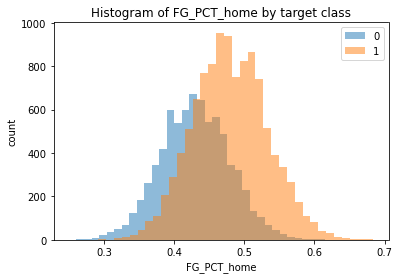

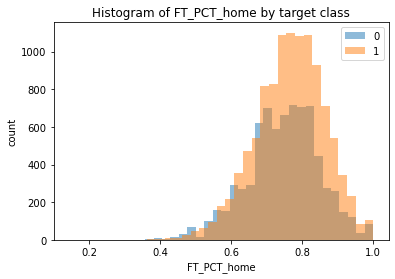

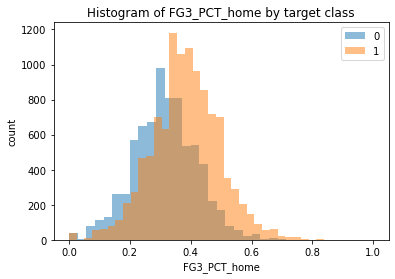

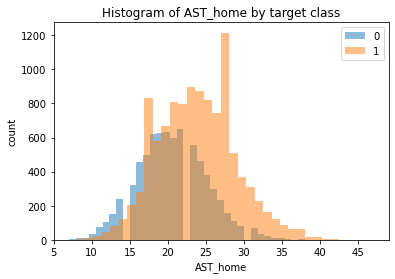

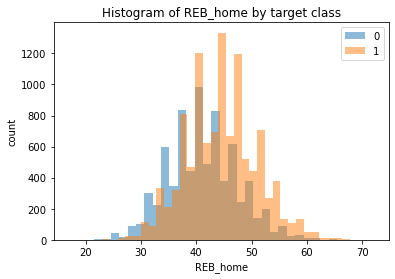

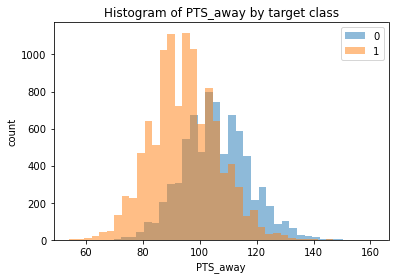

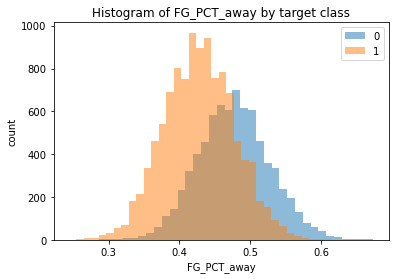

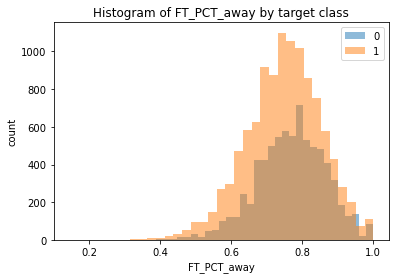

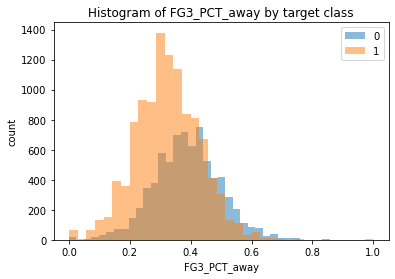

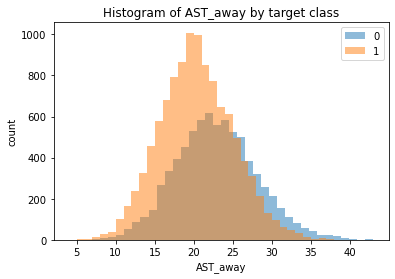

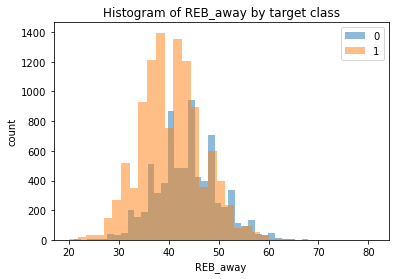

In [15]:
# Adapted from Homework 2
negative_examples = train.query("HOME_TEAM_WINS == 0")
positive_examples = train.query("HOME_TEAM_WINS == 1")

negative_examples = negative_examples[visualized_features]
positive_examples = positive_examples[visualized_features]

def plot_feature_hist(negative_examples, positive_examples, feature):
    plt.hist(negative_examples[feature], bins=35, color='tab:blue', label='0', alpha=0.5)
    plt.hist(positive_examples[feature], bins=35, color='tab:orange', label='1', alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.title('Histogram of ' + feature + ' by target class')
    plt.legend(loc='best') 

for f in visualized_features:
    plot_feature_hist(negative_examples, positive_examples, f)
    plt.show()  

#### 2(b)
rubric={points:5}

- Drop features that would not actually be available during deployment.
- Drop features for other reasons, e.g. they would not be useful for predicting the target.
- Provide a brief justification explaining the features you dropped.

#### Answer:
* To be clear, the goal is not to predict using actual post-game data, which team will win a game, because none of these features will be available before the game. Rather, it is to run scenarios with estimates of these features pre-game and mid-game, to predict a win or a loss. 
* `PTS_home` and `PTS_away` are dropped because they directly determine the target. It also isn't helpful because ultimately the end goal of the coach is to have a positive points differential anyways, whereas with the other features, a coach would be more likely to tinker with their decisions and make tradeoffs. Even mid-game, it makes sense to look at intermediate statistics to predict which team is playing the better game, but it doesn't make sense to look at points, because the team with higher points at the time is more likely to win.
* `GAME_DATE_EST` and `SEASON` are dropped because the game changes over time, but I wanted to capture more fundemental patterns in whether a game is won/lost based solely on features of that game, ignoring the temporal component.
* `GAME_ID`, `HOME_TEAM_ID`/`TEAM_ID_home`, and `VISITOR_TEAM_ID`/`TEAM_ID_away` were dropped because they are simply identifying data, and good/bad teams can change with the times.
* `GAME_STATUS_TEXT` was dropped because it is the same across all examples so isn't useful for prediction.

Actual features will be dropped in the next part

In [16]:
dropped_features = ['PTS_home', 'PTS_away', 'GAME_DATE_EST', 'SEASON', 'GAME_ID', 'HOME_TEAM_ID', 'TEAM_ID_home', 'VISITOR_TEAM_ID', 'TEAM_ID_away', 'GAME_STATUS_TEXT']
X_train = train.drop(columns=dropped_features + ['HOME_TEAM_WINS'])
y_train = train['HOME_TEAM_WINS']
X_test = test.drop(columns=dropped_features + ['HOME_TEAM_WINS'])
y_test = test['HOME_TEAM_WINS']

#### 2(c)
rubric={points:10}

- Build a preprocessing pipeline.

#### Answer:
Because all the data is numeric, the preprocessing pipeline just needs to impute in case there are missing values come deployment (i.e. a coach can't input a stat into the model), and scale.

In [17]:
imp = SimpleImputer(strategy='median')
scaler = StandardScaler()
preproc_pipe = Pipeline([('imp', imp),
                         ('scaler', scaler)])
preproc_pipe.fit(X_train)
pd.DataFrame(data=preproc_pipe.transform(X_train), index=X_train.index, columns=X_train.columns).head(3)

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away
15085,0.091348,0.067326,-1.514299,-0.098857,0.892342,-0.526693,0.060779,-0.436036,0.569649,0.484126
21928,0.601285,1.113086,0.069835,0.482578,1.502853,-1.300260,0.700036,-0.675755,-1.009138,-1.055816
1898,-1.684640,-1.695526,-0.199990,-1.649349,1.808109,-0.382774,-0.220106,2.547133,0.766997,2.024068


#### 2(d)
rubric={points:5}

- Try some models includng, at least:
    1. `DummyRegressor` or `DummyClassifer`, as appropriate
    2. `Ridge` or `LogisticRegression`, as appropriate
    3. `LGBMRegressor` or `LGBMClassifier`, as appropriate 


#### Answer:

##### Dummy Classifier

In [18]:
dc = DummyClassifier(strategy='prior')
dummy_pipe = Pipeline([('preproc', preproc_pipe),
                       ('dc', dc)])
print(f'Cross-validation Score: {cross_validate(dummy_pipe, X_train, y_train, return_train_score=True)["test_score"].mean()}')

Cross-validation Score: 0.594274276693086


##### Logistic Regression

In [19]:
lr = LogisticRegression()
lr_pipe = Pipeline([('preproc', preproc_pipe),
                    ('lr', lr)])
print(f'Cross-validation Score: {cross_validate(lr_pipe, X_train, y_train, return_train_score=True)["test_score"].mean()}')

Cross-validation Score: 0.8391055978302256


##### LGBM Classifier

In [20]:
lgbm = LGBMClassifier(random_state=123)
lgbm_pipe = Pipeline([('preproc', preproc_pipe),
                      ('lgbm', lgbm)])
print(f'Cross-validation Score: {cross_validate(lgbm_pipe, X_train, y_train, return_train_score=True)["test_score"].mean()}')

Cross-validation Score: 0.835912957137585


##### Random Forest Classifier

In [21]:
rf = RandomForestClassifier(random_state=123, n_jobs=-1)
rf_pipe = Pipeline([('preproc', preproc_pipe),
                    ('rf', rf)])
print(f'Cross-validation Score: {cross_validate(rf_pipe, X_train, y_train, return_train_score=True)["test_score"].mean()}')

Cross-validation Score: 0.8347764470531723


#### 2(e)
rubric={points:5}

- Hyperparameter tuning.

#### Answer:

I've chosen to go with `LogisticRegression` because it had slightly faster train times in my experience and similar (slightly higher) cross-validation accuracy to `LGBMClassifier` or `RandomForesetClassifier` (although this could just be because it had better default hyperparameters).

Through both `GridSearchCV` and `RandomizedSearchCV` it seems like the values of the hyperparameters don't vary the score drastically, as the top results are within standard deviations of one another, so I'll leave the `sklearn` defaults of `max_iter=100` and `C=1`.

##### Grid Search

In [22]:
param_grid = {
    "lr__max_iter" : [50, 100, 500, 1000],
    "lr__C" : [0.01, 0.05, 1, 5, 10, 50, 100]
}

grid_search = GridSearchCV(lr_pipe, param_grid, verbose=2, n_jobs=-1, cv=10)

In [23]:
grid_search.fit(X_train, y_train)
pd.DataFrame(grid_search.cv_results_)[['mean_test_score', 'std_test_score', 'param_lr__max_iter', 'param_lr__C', 'mean_fit_time', 'rank_test_score']].set_index('rank_test_score').sort_index().head(10)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    1.6s finished


,mean_test_score,std_test_score,param_lr__max_iter,param_lr__C,mean_fit_time
rank_test_score,,,,,
1,0.838348,0.007263,50,1,0.054501
1,0.838348,0.007263,1000,1,0.052202
1,0.838348,0.007263,100,1,0.054603
1,0.838348,0.007263,500,1,0.054299
5,0.838348,0.007145,50,0.05,0.052801
5,0.838348,0.007145,100,0.05,0.056203
5,0.838348,0.007145,500,0.05,0.055203
5,0.838348,0.007145,1000,0.05,0.051597
9,0.838294,0.007330,50,50,0.053801


In [24]:
grid_search.best_params_

{'lr__C': 1, 'lr__max_iter': 50}

##### Randomized Search

In [25]:
param_choices = {
    "lr__max_iter" : np.arange(50, 1000),
    "lr__C" : [0.01, 0.05, 1, 5, 10, 50, 100]
}

random_search = RandomizedSearchCV(lr_pipe, param_choices, n_iter = 120, verbose = 1, n_jobs = -1, cv=10, random_state = 123)

In [26]:
random_search.fit(X_train, y_train)
pd.DataFrame(random_search.cv_results_)[['mean_test_score', 'std_test_score', 'param_lr__max_iter', 'param_lr__C', 'mean_fit_time', 'rank_test_score']].set_index('rank_test_score').sort_index().head(10)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1169 out of 1200 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    4.9s finished


,mean_test_score,std_test_score,param_lr__max_iter,param_lr__C,mean_fit_time
rank_test_score,,,,,
1,0.838348,0.007263,869,1,0.051695
1,0.838348,0.007263,561,1,0.054699
1,0.838348,0.007263,610,1,0.052992
1,0.838348,0.007263,761,1,0.055206
1,0.838348,0.007263,719,1,0.056201
1,0.838348,0.007263,124,1,0.057208
1,0.838348,0.007263,905,1,0.053797
1,0.838348,0.007263,65,1,0.055800
1,0.838348,0.007263,995,1,0.053095


In [27]:
random_search.best_params_

{'lr__max_iter': 458, 'lr__C': 1}

#### 2(f)
rubric={points:5}

- Look at the sub-scores from the different folds of cross-validation and briefly discuss.


#### Answer:

It seems the validation scores are on average ~0.007 away from the mean, which is quite low. This gives me a higher degree of confidence that the model will most likely achieve the mean validation score of ~0.84.

In [28]:
cv_results = cross_validate(lr_pipe, X_train, y_train, return_train_score=True, cv=10)
cv_results = pd.DataFrame(data=cv_results).sort_values(by='test_score', ascending=False)
cv_results.index = range(len(cv_results))
cv_results

,fit_time,score_time,test_score,train_score
0,0.027997,0.002003,0.849567,0.837102
1,0.029000,0.001000,0.846861,0.837763
2,0.027996,0.002000,0.845779,0.837222
3,0.028997,0.002000,0.843615,0.837823
4,0.028001,0.001000,0.838657,0.838073
5,0.028001,0.001999,0.836039,0.839026
6,0.027000,0.002000,0.832702,0.839517
7,0.025999,0.002000,0.831710,0.839567
8,0.028000,0.001000,0.829545,0.839507
9,0.028072,0.001928,0.829004,0.839747


In [29]:
print(f'Mean of validation scores across folds: {np.mean(cv_results["test_score"])}')
print(f'Standard deviation of validation scores across folds: {np.std(cv_results["test_score"])}')

Mean of validation scores across folds: 0.8383480172597662
Standard deviation of validation scores across folds: 0.007262710529195648


#### 2(g)
rubric={points:5}

- Compute at least one relevant scoring metric aside from the default `.score()` and briefly discussing the result.


#### Answer:

From below, we note the following:
* We identified about 87.5% of actual home wins
* Of the games classified as home wins, about 85.6% of them were actual home wins
* Our validation f1, a metric that incoporates both precision and recall, was about 86.6%

Our model is slightly bias towards predicting (home) wins, because the data is about 60% positive class to about 40% negative class, so it makes sense that without `class_weight='balanced'`, the model has slightly higher recall (gets more actual wins correct), but lower precision (more likely to have predicted wins that are actually losses).

In [30]:
print('Average across folds:')
cv_results = pd.DataFrame(data=pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, return_train_score=True, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1'])).mean()).T
cv_results.index = ['home win (positive class)']
cv_results

Average across folds:


,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
home win (positive class),0.027999,0.0045,0.838348,0.838535,0.856052,0.856283,0.875238,0.875188,0.865508,0.865633


#### 2(h)
rubric={points:5}

- Evaluate your model on the test set and briefly discuss your level of confidence in whether this is an accurate assessment of your model's future deployment performance.

#### Answer:

The test score is slightly higher, but still within the standard deviation of the mean validation score, providing a higher degree of confidence that we have not overfitted on the validation set; and because we followed the golden rule and the sample distribution is very close to deployment (actual nba games), I do believe this is an accurate assessment of performance. However, this could be less accurate if rules or the game style changes significantly, for example the introduction of a 4-point line could reduce the importance of the other features in this model, or if 3-point shooting continues to become more popular, it might reduce the relative importance of rebounds, which currently impact the model more. In this case, the deployment data would have shifted, and our model may no longer achieve the same performance. 

In [31]:
lr_pipe.fit(X_train, y_train)
print(f'Final score on test data: {lr_pipe.score(X_test, y_test)}')

Final score on test data: 0.844363009269239


##### (Bonus) Feature Importances

For a coach, I think it would be interesting to see which factors tend to impact winning/losing the most, and I was a little surprised to discover that rebounds affected the model more than 3-point percentage.

In [32]:
pd.DataFrame(data=lr_pipe['lr'].coef_, index=['Coefficient'], columns=X_train.columns).T.sort_values(by='Coefficient', ascending=False)

,Coefficient
FG_PCT_home,1.384037
REB_home,0.584570
FG3_PCT_home,0.519101
FT_PCT_home,0.427616
AST_home,0.411902
AST_away,-0.396679
FT_PCT_away,-0.404309
FG3_PCT_away,-0.503623
REB_away,-0.592179
FG_PCT_away,-1.393888


## Exercise 3
rubric={points:10}

The following short-answer questions pertain to Lecture 19 on clustering.

1. What's the main difference between unsupervised and supervised learning?
2. When choosing $k$ in $k$-means, why not just choose the $k$ that leads to the smallest inertia (sum of squared distances within clusters)?
3. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with $k$-means?
4. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with DBSCAN?
5. For hierarchical clustering, we briefly discussed a few different methods for merging clusters: single linkage, average linkage, etc. Why do we have this added complication here - can't we just minimize distance like we did with $k$-means? 

#### Answer:
1. *Supervised* learning refers to machine learning problems where we try to predict *y* given *x*, but in *unsupervised* learning we do not have target labels telling us the correct answer. Therefore, tasks like nearest neighbors or k-means are unsupervised because we are trying to get the machine to analyze / learn a pattern without labelled correct answers.
2. As we increase *k*, inertia will decrease because groups are smaller/tighter, but we might be artificially clustering more groups than naturally exist. By using the elbow-plotting method, we can choose the highest value of *k* that leads to significant drops in inertia from the previous value, allowing us to balance small inertia with not having excessive clusters.
3. We could iterate through each point and generate its distance from each cluster centre, and examine points that either have large distances from their clustre centre or a large sum of the magnitudes of distances from all cluster centres as potential outliers. We could also use the first method discussed below for DBSCAN. 
4. We could look at the silhouette plot for our clustering and for each cluster examine the bottom-most (shortest) bar(s) as a possible outlier(s); this is a point(s) that is most different from the cluster. We could also plot the clusterings (perhaps using PCA to reduce dimensionality) and examine points that were not clustered by DBSCAN as potential outliers.
5. Unlike k-means, we do not have a cluster centre for each hierarchical cluster, which would otherwise be used as a point with which to measure distance from that cluster to something else. Therefore, we must decide how to measure the distance from a hierarchical cluster to another point (which point to measure from).

## Submission to Canvas

**IF YOU ARE WORKING WITH A PARTNER** please form the group before submitting - see instructions [here](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md#partners).

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Save your notebook.
3. Convert your notebook to `.html` format using the `convert_notebook()` function below **or** by `File -> Export Notebook As... -> Export Notebook to HTML`.
4. Run the code `submit()` below to go through an interactive submission process to Canvas.
>For this step, you will need a Canvas *Access Token* token. If you haven't already got one, log-in to Canvas, click `Account` (top-left of the screen), then `Settings`, then scroll down until you see the `+ New Access Token` button. Click that button, give your token any name you like and set the expiry date to Dec 31, 2020. Then click `Generate token`. Save this token in a safe place on your computer as you'll need it for all assignments. Treat the token with as much care as you would an important password. 

Note: for those having trouble with the Jupyter widgets and the dropdowns: if you add the argument `no_widgets=True` to your `submit` call, it should let you do a text-based entry of your key and avoid the dropdowns altogether. If this doesn't work, you probably need to upgrade to the latest version of `canvasutils` with `pip install canvasutils -U` from your terminal with your environment activated.


In [33]:
from canvasutils.submit import submit, convert_notebook

# Note: the canvasutils package should have been installed as part of your environment setup - 
# see https://github.com/UBC-CS/cpsc330/blob/master/docs/setup.md

In [36]:
# convert_notebook("hw8.ipynb", "html")  # uncomment and run when you want to try convert your notebook to HTML (or you can convert manually from the File menu)

Notebook successfully converted! 


In [37]:
# submit(course_code=53561, token=False)  # uncomment and run when ready to submit 

Please paste your token here and then hit enter:


 ······································································



Token successfully entered - thanks!


Select an assignment to submit to:


Output()